### <font color='green'>Objetivo do Projeto: Verificar quais variáveis são mais importantes para o resultado do aluno no exame escolar.</font>

Link do dataset: https://www.kaggle.com/datasets/lainguyn123/student-performance-factors

In [1]:
# Imports
import sklearn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import warnings
warnings.filterwarnings('ignore')

### <font color='green'>Exploração dos Dados</font>

In [2]:
# Carregando o dataset
df = pd.read_csv('StudentPerformanceFactors.csv')

In [3]:
# Verificando os primeiros registros do dataset
df.head()

,Hours_Studied,Attendance,Parental_Involvement,Access_to_Resources,Extracurricular_Activities,Sleep_Hours,Previous_Scores,Motivation_Level,Internet_Access,Tutoring_Sessions,Family_Income,Teacher_Quality,School_Type,Peer_Influence,Physical_Activity,Learning_Disabilities,Parental_Education_Level,Distance_from_Home,Gender,Exam_Score
0,23,84,Low,High,No,7,73,Low,Yes,0,Low,Medium,Public,Positive,3,No,High School,Near,Male,67
1,19,64,Low,Medium,No,8,59,Low,Yes,2,Medium,Medium,Public,Negative,4,No,College,Moderate,Female,61
2,24,98,Medium,Medium,Yes,7,91,Medium,Yes,2,Medium,Medium,Public,Neutral,4,No,Postgraduate,Near,Male,74
3,29,89,Low,Medium,Yes,8,98,Medium,Yes,1,Medium,Medium,Public,Negative,4,No,High School,Moderate,Male,71
4,19,92,Medium,Medium,Yes,6,65,Medium,Yes,3,Medium,High,Public,Neutral,4,No,College,Near,Female,70


In [4]:
# Shape (linhas / colunas)
df.shape

(6607, 20)

In [5]:
# Info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6607 entries, 0 to 6606
Data columns (total 20 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   Hours_Studied               6607 non-null   int64 
 1   Attendance                  6607 non-null   int64 
 2   Parental_Involvement        6607 non-null   object
 3   Access_to_Resources         6607 non-null   object
 4   Extracurricular_Activities  6607 non-null   object
 5   Sleep_Hours                 6607 non-null   int64 
 6   Previous_Scores             6607 non-null   int64 
 7   Motivation_Level            6607 non-null   object
 8   Internet_Access             6607 non-null   object
 9   Tutoring_Sessions           6607 non-null   int64 
 10  Family_Income               6607 non-null   object
 11  Teacher_Quality             6529 non-null   object
 12  School_Type                 6607 non-null   object
 13  Peer_Influence              6607 non-null   obje

In [6]:
# Verificando se há valores ausentes
missing_values = df.isna().sum()
print(missing_values[missing_values > 0])

Teacher_Quality             78
Parental_Education_Level    90
Distance_from_Home          67
dtype: int64


In [7]:
perc_miss_values = (missing_values / len(df)) * 100
print(perc_miss_values[perc_miss_values > 0].apply(lambda x: f'{x:.2f}%'))

Teacher_Quality             1.18%
Parental_Education_Level    1.36%
Distance_from_Home          1.01%
dtype: object


In [8]:
# Não será feito nenhuma imputação de dados nos valores ausentes, visto que são poucos registros em comparação ao dataset total.

# Excluindo todos os valores ausentes
df = df.dropna()

In [9]:
# Verificando se há valores ausentes
missing_values = df.isna().sum()
print(missing_values[missing_values > 0])

Series([], dtype: int64)


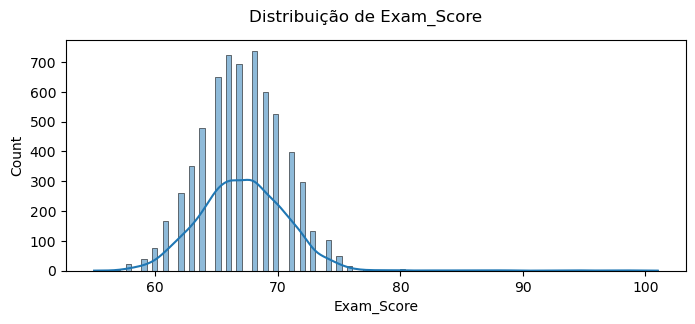

In [10]:
# Distribuição do Exam_Score
fig, axes = plt.subplots(1, 1, figsize = (8,3))
fig.suptitle('Distribuição de Exam_Score')
sns.histplot(df['Exam_Score'], kde= True);

Text(0, 0.5, 'Exam Score')

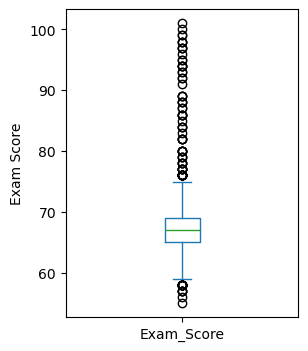

In [11]:
# Boxplot da variável alvo

# Define o tamanho da figura
plt.figure(figsize=(3, 4)) 

# Cria o boxplot
ax = (df['Exam_Score']).plot.box()
ax.set_ylabel('Exam Score')

Realizando uma breve análise na variável alvo "Exam Score", é possível ver que os dados não seguem uma distribuição normal, visto que olhando pelo boxplot há diversos pontos além do limite superior e inferior, indicando que temos outliers, ou seja, alunos que estiveram bem acima da média geral no exame, além daqueles no qual estiveram também bem abaixo da média.

### <font color='green'>Estratégia 1: One-Hot Enconding</font>

O One-Hot Enconding é um método utilizado para transformar variáveis categóricas em numéricas, visto que modelos de Machine Learning apenas entendem números. Sendo assim esse método irá criar para cada palavra diferente em uma variável uma nova coluna binária. Por exemplo, na variável Internet Access, há nas linhas a resposta yes e no, sendo assim será criado uma nova coluna Internet_Access_Yes onde será colocado o valor 1 onde anteriormente havia o Yes como resposta na linha e 0 quando não havia. O mesmo será feito para Internet_Access_No.

In [12]:
# Selecionando as variáveis independentes (X) e a dependente (y)
X = df.drop('Exam_Score', axis=1)
y = df['Exam_Score']

In [13]:
# Separa as variáveis categóricas e numéricas, pois terão processamentos diferentes
categorical_features = df.select_dtypes(include=['object']).columns.tolist()
numerical_features = df.drop('Exam_Score', axis=1).select_dtypes(exclude=['object']).columns.tolist() 

In [14]:
print(categorical_features)
print(numerical_features)

['Parental_Involvement', 'Access_to_Resources', 'Extracurricular_Activities', 'Motivation_Level', 'Internet_Access', 'Family_Income', 'Teacher_Quality', 'School_Type', 'Peer_Influence', 'Learning_Disabilities', 'Parental_Education_Level', 'Distance_from_Home', 'Gender']
['Hours_Studied', 'Attendance', 'Sleep_Hours', 'Previous_Scores', 'Tutoring_Sessions', 'Physical_Activity']


In [15]:
# Cria o transformador para variáveis categóricas
categorical_transformer = OneHotEncoder(drop = 'first')

In [16]:
# Cria o transformador para variáveis numéricas
# Não se aplica o StandardScaler após aplicar o OneHotEncoder, pois este já coloca as variáveis na mesma escala.
numerical_transformer = StandardScaler()

In [17]:
# Combinando os transformadores
# Pré-processamento: Codificação One-Hot para variáveis categóricas e padronização para numéricas
preprocessor_v1 = ColumnTransformer(
    transformers = [
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

In [18]:
# Criando o pipeline com o processamento e com o modelo
modelo_v1 = Pipeline(steps = [('preprocessor', preprocessor_v1), ('regressor', LinearRegression())])

### <font color='green'>Criando o modelo de Machine Learning utilizando a estratégia 1.</font>

In [19]:
# Dividindo os dados em treino e teste
X_treino, X_teste, y_treino, y_teste = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [20]:
# Fit somente com dados de treino
modelo_v1.fit(X_treino, y_treino)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['Hours_Studied',
                                                   'Attendance', 'Sleep_Hours',
                                                   'Previous_Scores',
                                                   'Tutoring_Sessions',
                                                   'Physical_Activity']),
                                                 ('cat',
                                                  OneHotEncoder(drop='first'),
                                                  ['Parental_Involvement',
                                                   'Access_to_Resources',
                                                   'Extracurricular_Activities',
                                                   'Motivation_Level',
                                                   'Internet_Access',
                                                   'Family_Income',
                                                   'Teacher_Quality',
                                                   'School_Type',
                                                   'Peer_Influence',
                                                   'Learning_Disabilities',
                                                   'Parental_Education_Level',
                                                   'Distance_from_Home',
                                                   'Gender'])])),
                ('regressor', LinearRegression())])

In [21]:
# Usamos predict nos dados de teste
y_pred = modelo_v1.predict(X_teste)

In [22]:
# Avaliando o modelo
rmse_v1 = mean_squared_error(y_teste, y_pred, squared = False)
r2_v1 = r2_score(y_teste, y_pred)

In [23]:
print(rmse_v1)

2.0428563488918923


Interpretando o RMSE:

O RMSE, ou Raiz do Erro Quadrático Médio (Root Mean Squared Error), é uma métrica utilizada para avaliar o desempenho de modelos de aprendizado de máquina, especialmente em problemas de regressão. Ele mede a diferença média entre os valores preditos pelo modelo e os valores reais do conjunto de dados. Para interpretá-lo, imagine que o RMSE representa a distância média, na mesma unidade dos seus dados, que as previsões do seu modelo estão do valor real. Quanto menor o valor do RMSE, melhor o seu modelo está performando, pois significa que as previsões estão mais próximas dos valores reais.

Um RMSE de 2.04 significa que, em média, as previsões do seu modelo estão desviando 2.04 unidades do valor real. Para interpretar se esse valor é bom ou ruim, você precisa considerar o contexto do problema e dos seus dados.

Veja alguns pontos importantes:

Unidade de medida: O RMSE é expresso na mesma unidade dos seus dados. Se você está prevendo preços de casas em milhares de dólares, por exemplo, um RMSE de 2.04 significa que, em média, suas previsões estão errando em $2.040,00.
Escala dos dados: Um RMSE de 2.04 pode ser muito bom em um problema onde os valores variam de 0 a 100, mas pode ser ruim se os valores variam de 0 a 1.

In [24]:
print(r2_v1)

0.7314386522127074


Interpretando o R²:

O R² (R-quadrado), também conhecido como coeficiente de determinação, é uma métrica que indica a capacidade do modelo de regressão de explicar a variabilidade dos dados em torno de sua média. Em termos mais simples, ele mostra o quão bem o modelo se ajusta aos dados reais, variando de 0 a 1.

Um R² de 0.73 significa que seu modelo consegue explicar 73% da variação nos seus dados. Ou seja, 73% das mudanças na sua variável dependente podem ser explicadas pelas variáveis independentes incluídas no seu modelo. Os 27% restantes da variabilidade podem ser influenciados por fatores que não foram incluídos no modelo ou por aleatoriedade.

Interpretando o valor:

0.73 é geralmente considerado um valor bom: Isso indica um ajuste relativamente bom do modelo aos dados.
Quanto mais próximo de 1, melhor: Um R² de 1 significaria que o modelo explica 100% da variabilidade nos dados, o que é raro em cenários reais.

### <font color='green'>Estratégia 2: Ordinal Label Enconding.</font>

O Ordinal Label Encoding é uma técnica utilizada para codificar variáveis categóricas que possuem uma ordem natural ou hierárquica entre suas categorias.  Ele funciona atribuindo um valor numérico inteiro a cada categoria, respeitando a ordem intrínseca. Por exemplo, se temos uma variável "Tamanho" com as categorias "Pequeno", "Médio" e "Grande", podemos usar o Ordinal Label Encoding para representá-las como 1, 2 e 3, respectivamente.  A diferença fundamental entre o Ordinal Label Encoding e o One-Hot Encoding é que o primeiro considera a ordem entre as categorias, enquanto o segundo trata todas as categorias como independentes e sem relação de ordem. O One-Hot Encoding cria novas colunas binárias para cada categoria, evitando que o modelo interprete as categorias como valores numéricos ordinais, o que pode ser inadequado para variáveis sem uma ordem natural.  


In [25]:
df.head(1)

,Hours_Studied,Attendance,Parental_Involvement,Access_to_Resources,Extracurricular_Activities,Sleep_Hours,Previous_Scores,Motivation_Level,Internet_Access,Tutoring_Sessions,Family_Income,Teacher_Quality,School_Type,Peer_Influence,Physical_Activity,Learning_Disabilities,Parental_Education_Level,Distance_from_Home,Gender,Exam_Score
0,23,84,Low,High,No,7,73,Low,Yes,0,Low,Medium,Public,Positive,3,No,High School,Near,Male,67


In [26]:
# Separa as variáveis categóricas em ordinal e nominal e numéricas, pois terão processamentos diferentes
categorical_features_ordinal = ['Parental_Involvement', 'Access_to_Resources', 'Motivation_Level', 'Family_Income', 'Teacher_Quality']
categorical_features_nominal = df.select_dtypes(include=['object']).columns.tolist()
categorical_features_nominal = [col for col in categorical_features_nominal if col not in categorical_features_ordinal + ['Exam_Score']]
numerical_features = df.drop('Exam_Score', axis=1).select_dtypes(exclude=['object']).columns.tolist() 

In [27]:
print(categorical_features_ordinal)
print(categorical_features_nominal)
print(numerical_features)

['Parental_Involvement', 'Access_to_Resources', 'Motivation_Level', 'Family_Income', 'Teacher_Quality']
['Extracurricular_Activities', 'Internet_Access', 'School_Type', 'Peer_Influence', 'Learning_Disabilities', 'Parental_Education_Level', 'Distance_from_Home', 'Gender']
['Hours_Studied', 'Attendance', 'Sleep_Hours', 'Previous_Scores', 'Tutoring_Sessions', 'Physical_Activity']


In [28]:
# Transformador para as variáveis categóricas ordinais
categorical_transformer_ordinal = OrdinalEncoder()

In [29]:
# Transformador para as variáveis categóricas nominais
categorical_transformer_nominal = OneHotEncoder(drop = 'first')

In [30]:
# Cria o transformador para variáveis numéricas
numerical_transformer = StandardScaler()

In [31]:
# Combinando os transformadores
preprocessor_v2 = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat_nominal', categorical_transformer_nominal, categorical_features_nominal),
        ('cat_ordinal', categorical_transformer_ordinal, categorical_features_ordinal)
    ])

In [32]:
# Pipeline
modelo_dsa_v2 = Pipeline(steps = [('preprocessor', preprocessor_v2), ('regressor', LinearRegression())])

### <font color='green'>Criando o modelo de Machine Learning utilizando a estratégia 2.</font>

In [33]:
# Fit do modelo com dados de treino
modelo_dsa_v2.fit(X_treino, y_treino)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['Hours_Studied',
                                                   'Attendance', 'Sleep_Hours',
                                                   'Previous_Scores',
                                                   'Tutoring_Sessions',
                                                   'Physical_Activity']),
                                                 ('cat_nominal',
                                                  OneHotEncoder(drop='first'),
                                                  ['Extracurricular_Activities',
                                                   'Internet_Access',
                                                   'School_Type',
                                                   'Peer_Influence',
                                                   'Learning_Disabilities',
                                                   'Parental_Education_Level',
                                                   'Distance_from_Home',
                                                   'Gender']),
                                                 ('cat_ordinal',
                                                  OrdinalEncoder(),
                                                  ['Parental_Involvement',
                                                   'Access_to_Resources',
                                                   'Motivation_Level',
                                                   'Family_Income',
                                                   'Teacher_Quality'])])),
                ('regressor', LinearRegression())])

In [34]:
# Previsões com dados de teste
y_pred_v2 = modelo_dsa_v2.predict(X_teste)

In [35]:
# Avaliando o modelo atualizado
rmse_v2 = mean_squared_error(y_teste, y_pred_v2, squared = False)
r2_v2 = r2_score(y_teste, y_pred_v2)

In [36]:
print(rmse_v2)

2.2516456728904886


In [37]:
print(r2_v2)

0.6737369068157957


In [38]:
# Tabela com os resultados

# Cria um dicionário com os dados
dados = {
    "Modelo": ["Modelo 1", "Modelo 2"],
    "RMSE": [rmse_v1, rmse_v2],
    "R²": [r2_v1, r2_v2]
}

# Cria o DataFrame
df_resultados = pd.DataFrame(dados)

# Imprime o DataFrame
print(df_resultados)

     Modelo      RMSE        R²
0  Modelo 1  2.042856  0.731439
1  Modelo 2  2.251646  0.673737


### <font color='green'>Análise dos Resultados.</font>

Comparando os dois blocos de código que implementam modelos de regressão linear, notamos diferenças nas métricas de avaliação (RMSE e R²) devido à mudança na estratégia de tratamento das variáveis categóricas.

Enquanto a Versão 1 aplica o OneHotEncoder com drop='first' a todas as variáveis categóricas, a Versão 2 diferencia as variáveis nominais das ordinais. Nas variáveis nominais, mantém-se o OneHotEncoder, enquanto nas ordinais utiliza-se o OrdinalEncoder. Essa última escolha visa preservar a ordem natural das categorias, o que poderia, em teoria, aprimorar a performance do modelo.

Entretanto, os resultados obtidos demonstram um desempenho ligeiramente superior da Versão 1, com melhores valores de RMSE e R². Isso sugere que, neste caso específico, a codificação ordinal não agregou informação relevante para o modelo, e a representação simplificada através do OneHotEncoder mostrou-se mais eficaz.

É fundamental destacar que a escolha ideal entre as técnicas de codificação depende da natureza das variáveis e da relação destas com a variável alvo. A complexidade adicional da codificação ordinal só se justifica quando a ordem das categorias realmente contribui para a capacidade preditiva do modelo.

Em situações onde a performance não corresponde ao esperado, como observado na Versão 2, recomenda-se investigar a relação entre as variáveis ordinais e a variável dependente, buscando entender se a codificação ordinal é realmente adequada ou se ajustes no modelo, como a seleção de variáveis ou otimização de hiperparâmetros, são necessários.

### <font color='green'>Analisando as relações da variável alvo com as variáveis preditoras.</font>

In [39]:
# Para extrair os coeficientes, precisamos acessar o regressor dentro do pipeline...
model_regressor = modelo_v1.named_steps['regressor']

In [40]:
# ... e também tratar a transformação One-Hot para obter os nomes das variáveis
atrib_cat = modelo_v1.named_steps['preprocessor'].transformers_[1][1].get_feature_names_out(categorical_features)

In [41]:
atrib_cat

array(['Parental_Involvement_Low', 'Parental_Involvement_Medium',
       'Access_to_Resources_Low', 'Access_to_Resources_Medium',
       'Extracurricular_Activities_Yes', 'Motivation_Level_Low',
       'Motivation_Level_Medium', 'Internet_Access_Yes',
       'Family_Income_Low', 'Family_Income_Medium', 'Teacher_Quality_Low',
       'Teacher_Quality_Medium', 'School_Type_Public',
       'Peer_Influence_Neutral', 'Peer_Influence_Positive',
       'Learning_Disabilities_Yes',
       'Parental_Education_Level_High School',
       'Parental_Education_Level_Postgraduate',
       'Distance_from_Home_Moderate', 'Distance_from_Home_Near',
       'Gender_Male'], dtype=object)

In [42]:
# Combinando os nomes das variáveis numéricas e categóricas transformadas
nomes_todos_atributos = numerical_features + list(atrib_cat)

In [43]:
nomes_todos_atributos

['Hours_Studied',
 'Attendance',
 'Sleep_Hours',
 'Previous_Scores',
 'Tutoring_Sessions',
 'Physical_Activity',
 'Parental_Involvement_Low',
 'Parental_Involvement_Medium',
 'Access_to_Resources_Low',
 'Access_to_Resources_Medium',
 'Extracurricular_Activities_Yes',
 'Motivation_Level_Low',
 'Motivation_Level_Medium',
 'Internet_Access_Yes',
 'Family_Income_Low',
 'Family_Income_Medium',
 'Teacher_Quality_Low',
 'Teacher_Quality_Medium',
 'School_Type_Public',
 'Peer_Influence_Neutral',
 'Peer_Influence_Positive',
 'Learning_Disabilities_Yes',
 'Parental_Education_Level_High School',
 'Parental_Education_Level_Postgraduate',
 'Distance_from_Home_Moderate',
 'Distance_from_Home_Near',
 'Gender_Male']

In [44]:
# Coeficientes do modelo
coeficientes = model_regressor.coef_

In [45]:
coeficientes

array([ 1.77594234,  2.29617602, -0.01882632,  0.69993173,  0.5945878 ,
        0.20711834, -2.01234139, -1.03853331, -2.05032244, -1.01082453,
        0.56672263, -1.10729809, -0.59888074,  0.9006084 , -1.14852255,
       -0.62083425, -1.05051238, -0.60615018,  0.04895936,  0.56186729,
        1.01488049, -0.87048418, -0.47620465,  0.52157639,  0.30496393,
        0.84182865, -0.01080161])

In [46]:
# Criando um DataFrame para melhor visualização
dsa_coef_df = pd.DataFrame({'Atributo': nomes_todos_atributos, 'Coeficiente': coeficientes})


In [47]:
# Ordenando os coeficientes por magnitude (valor absoluto)
dsa_coef_df = dsa_coef_df.reindex(dsa_coef_df.Coeficiente.abs().sort_values(ascending = False).index)

In [48]:
dsa_coef_df.head(10)

,Atributo,Coeficiente
1,Attendance,2.296176
8,Access_to_Resources_Low,-2.050322
6,Parental_Involvement_Low,-2.012341
0,Hours_Studied,1.775942
14,Family_Income_Low,-1.148523
11,Motivation_Level_Low,-1.107298
16,Teacher_Quality_Low,-1.050512
7,Parental_Involvement_Medium,-1.038533
20,Peer_Influence_Positive,1.014880
9,Access_to_Resources_Medium,-1.010825


Para interpretar a relação das variáveis preditoras com a variável alvo, será feito uma explicação das 10 variáveis preditoras que são mais significativas para o Exam Score.

Variáveis com Impacto Positivo:

Attendance (Participação em Aulas): Coeficiente = 2.296176. A frequência às aulas demonstra ser um fator crucial para alcançar boas notas. Um aumento na Attendance está diretamente relacionado a umaumento esperado na Exam_Score, sendo este o fator com maior influência positiva dentre as variáveis analisadas.

Hours_Studied (Horas de Estudo): Coeficiente = 1.775942. Como esperado, dedicar mais tempo ao estudo também contribui positivamente para o desempenho no exame. Cada hora adicional de estudo reflete positivamente na nota final, reforçando a importância da dedicação individual.

PeerInfluencePositive (Influência Positiva dos Colegas): Coeficiente = 1.014880. O ambiente social também exerce influência no desempenho escolar. Ter colegas com atitude positiva em relação aos estudos impulsiona a nota do exame, demonstrando que o apoio mútuo e a troca de experiências são fatores relevantes.

Variáveis com Impacto Negativo:

AccesstoResources_Low (Baixo Acesso a Recursos): Coeficiente = -2.050322. A desigualdade de oportunidades fica evidente ao analisarmos o impacto do acesso a recursos. A falta de acesso adequado prejudica significativamente o desempenho dos alunos, sendo este o fator com maior impacto negativo na nota do exame.

ParentalInvolvementLow (Baixa Participação dos Pais): Coeficiente = -2.012341. A participação dos pais na vida escolar dos filhos é fundamental. A falta dessa participação acarreta uma queda expressiva no desempenho dos alunos, ressaltando a importância do apoio familiar na trajetória educacional.

FamilyIncomeLow (Baixa Renda Familiar): Coeficiente = -1.148523. Aspectos socioeconômicos também desempenham um papel importante. Alunos de famílias com menor renda familiar tendem a apresentar notas mais baixas, evidenciando a necessidade de políticas públicas que mitiguem as desigualdades e promovam oportunidades iguais para todos.

MotivationLevelLow (Baixo Nível de Motivação): Coeficiente = -1.107298. A motivação é um fator intrínseco essencial para o aprendizado. Alunos desmotivados tendem a ter um desempenho inferior, reforçando a importância de estímulos e estratégias que possibilitem o desenvolvimento do interesse e engajamento dos estudantes.

TeacherQualityLow (Baixa Qualidade do Professor): Coeficiente = -1.050512. A qualidade do corpo docente é crucial para o aprendizado. Professores com baixa qualificação impactam negativamente o desempenho dos alunos, destacando a importância de investimentos na formação e valorização dos profissionais da educação.

ParentalInvolvementMedium (Participação Moderada dos Pais): Coeficiente = -1.038533. É notável que mesmo um nível moderado de participação dos pais, quando comparado à alta participação, ainda apresente um efeito negativo no desempenho do aluno. Isso demonstra que a participação ativa e constante dos pais é um diferencial importante na trajetória escolar.

AccesstoResources_Medium (Acesso Médio a Recursos): Coeficiente = -1.010825. A mesma lógica se aplica ao acesso a recursos. Ter um acesso mediano, embora seja melhor do que o acesso baixo, ainda representa uma desvantagem quando comparado ao acesso amplo a recursos.

Em suma, a análise dos coeficientes revela os principais fatores que influenciam o desempenho dos alunos nas provas. Fica clara a necessidade de investimentos em áreas como infraestrutura escolar, qualificação dos professores, programas de apoio familiar e incentivo à motivação dos estudantes.


### <font color='green'>Sistema e Versões dos Pacotes.</font>

In [49]:
%reload_ext watermark
%watermark -v -m
%watermark --iversions

Python implementation: CPython
Python version       : 3.12.4
IPython version      : 8.25.0

Compiler    : MSC v.1929 64 bit (AMD64)
OS          : Windows
Release     : 10
Machine     : AMD64
Processor   : Intel64 Family 6 Model 186 Stepping 3, GenuineIntel
CPU cores   : 12
Architecture: 64bit

seaborn   : 0.13.2
pandas    : 2.2.2
sklearn   : 1.4.2
matplotlib: 3.8.4
numpy     : 1.26.4

